In [1]:
from nonasymptotic.envs import StraightLine
from nonasymptotic.prm import SimpleRadiusPRM, SimpleNearestNeighborRadiusPRM

import numpy as np
import matplotlib.pyplot as plt

Tue Feb 20 14:20:06 2024 Building RP forest with 11 trees
Tue Feb 20 14:20:08 2024 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations
Certified maximal correct connection radius: 0.115614


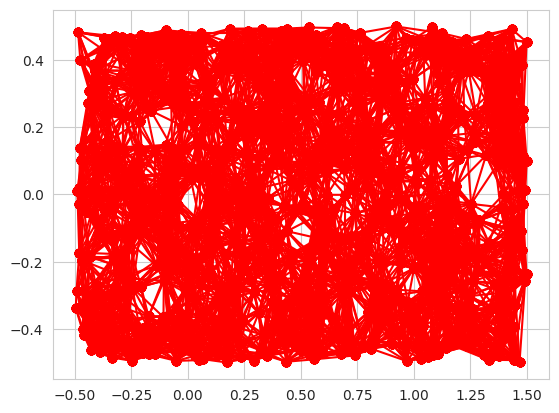

N nodes: 1000
N edges: 13665


In [2]:
seed = 1
prm_env_2d = StraightLine(dim=2, delta_clearance=0.5, seed=seed)
# prm = SimpleRadiusPRM(0.1, prm_env_2d.is_motion_valid, prm_env_2d.sample_from_env, prm_env_2d.distance_to_path, seed=seed,
#                 verbose=True)
prm = SimpleNearestNeighborRadiusPRM(32, 
                                     prm_env_2d.is_motion_valid, 
                                     prm_env_2d.sample_from_env, 
                                     prm_env_2d.distance_to_path, seed=seed, verbose=True)
prm.grow_to_n_samples(1000)

plt.figure()
for u, v in prm.prm_graph.iterEdges():
    coords_u = prm.prm_samples[u]
    coords_v = prm.prm_samples[v]

    plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')

plt.show()

# some other computations to help other visual tests later on:
print('N nodes: %i' % prm.num_vertices())
print('N edges: %i' % prm.num_edges())


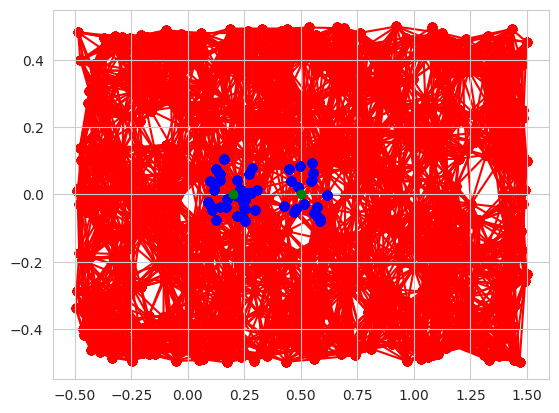

In [3]:
start = np.array([0.2, 0.00])
goal = np.array([0.5, 0.0])
pair_coords, _, pair_ids = prm.query_all_graph_connections(start, goal)

plt.figure()
for u, v in prm.prm_graph.iterEdges():
    coords_u = prm.prm_samples[u]
    coords_v = prm.prm_samples[v]

    plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-', zorder=0)

for u, v in pair_coords:
    plt.scatter([u[0], v[0]], [u[1], v[1]], color='blue', zorder=1)
    
plt.scatter([start[0], goal[0]], [start[1], goal[1]], color='green', zorder=2)
    

plt.show()


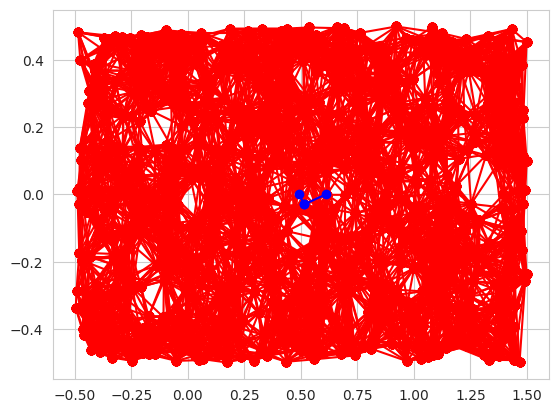

In [11]:
start = np.array([0.49323946, 0.0])
goal = np.array([0.60942998, 0.0])
d, path = prm.query_best_solution(start, goal)

plt.figure()
for u, v in prm.prm_graph.iterEdges():
    coords_u = prm.prm_samples[u]
    coords_v = prm.prm_samples[v]

    plt.plot([coords_u[0], coords_v[0]], [coords_u[1], coords_v[1]], 'ro-')

for i in range(len(path) - 1):
    u, v = path[i], path[i+1]
    plt.plot([u[0], v[0]], [u[1], v[1]], 'bo-')

plt.plot([start[0], path[0, 0]], [start[1], path[0, 1]], 'bo-')
plt.plot([goal[0], path[-1, 0]], [goal[1], path[-1, 1]], 'bo-')

plt.show()


In [6]:
import time

times = []
for _ in range(10):
    t_start = time.process_time()
    prm_env_2d.is_prm_epsilon_delta_complete(prm, 0.15, n_samples_per_check=100, timeout=60.0, area_tol=1e-6, vis=False)
    t_end = time.process_time()
    times.append(t_end - t_start)
    
print('mean: %f, std: %f' % (np.mean(times), np.std(times)))

not e-d complete! failing query: [0.49323946 0.60942998]
not e-d complete! failing query: [0.49313798 0.60925114]
not e-d complete! failing query: [0.34907317 0.4701324 ]
not e-d complete! failing query: [0.49558754 0.62943904]
not e-d complete! failing query: [0.37125938 0.48721161]
not e-d complete! failing query: [0.49615538 0.62956177]
not e-d complete! failing query: [0.37024311 0.48659818]
not e-d complete! failing query: [0.49247169 0.6096982 ]
not e-d complete! failing query: [0.37532475 0.49188507]
not e-d complete! failing query: [0.49841472 0.62568312]
mean: 0.493404, std: 0.211623


In [10]:
prm.query_best_solution(np.array([0.49324, 0.0]), np.array([0.60943, 0.0]))[0] + 1.15 * (0.49324 - 0.60943)

0.0024814354211474543